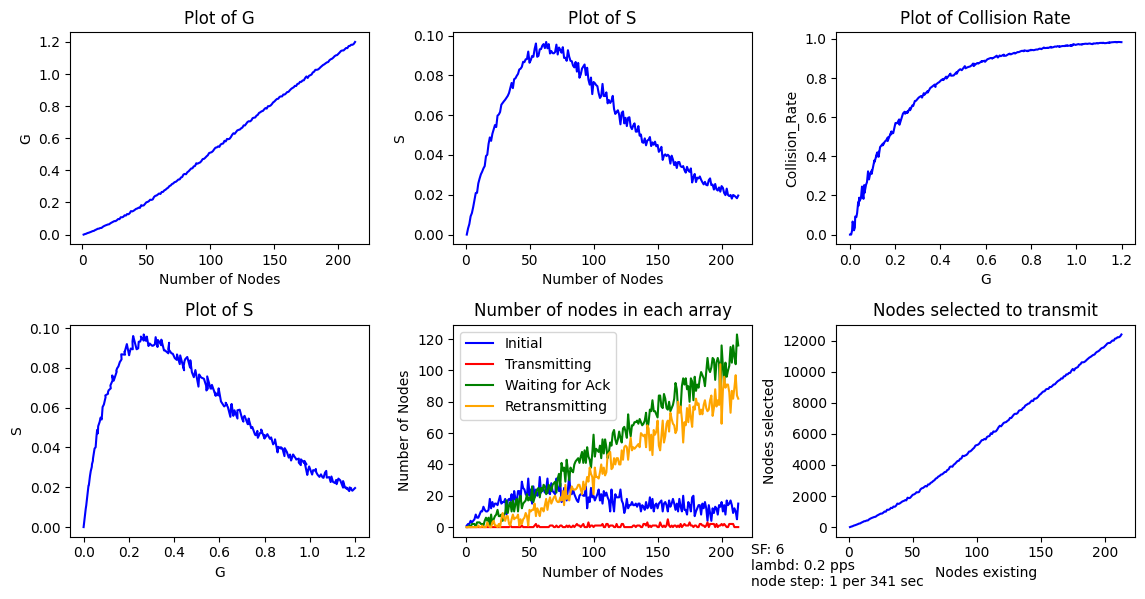

KeyboardInterrupt: 

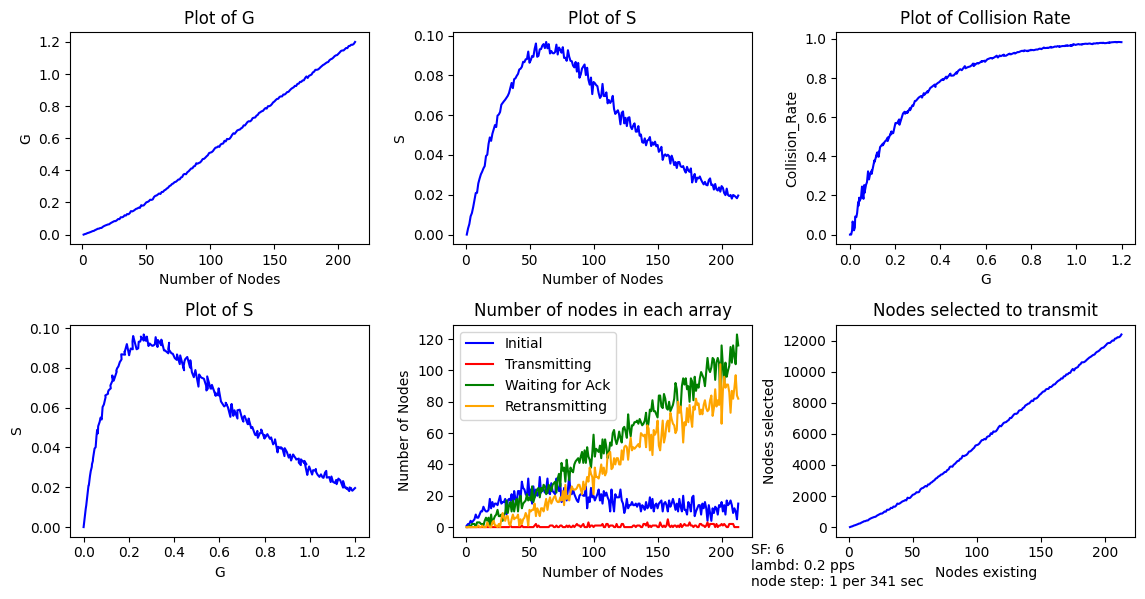

In [1]:
from IPython.display import display, clear_output
from Node_Class import Node
from Gateway_Class import Gateway
from Simulation_Class import Simulation
import Time_on_Air_Calculator as ToA_calc
from Tx_mode_functions import select_nodes_to_transmit, check_collisions, check_uplink_finished, update_time_lived
from Rx_mode_functions import check_transmission_success
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

# Parameters for ToA calculation
BW = 125000
SF = 6
preamble = 8
payload = 25
header = 1
CRC = 1
DE = 0
CR = 1

#Time related parameters
time = 0
RX_delay1 = 1000
min_timeout_for_ack = 1000
max_timeout_for_ack = 3000

#Node_related parameters
lambd = 1/5000
node_step = int(1024000/3)

#Lists to store nodes in different states
node_list = []
nodes_to_retransmit = []
nodes_transmitting = []
waiting_for_ack = []

#Lists to store metrics for the plots
S = []
G = []
collision_rate = []
nodes_selected = []
len_node_list = []
len_nodes_transmitting = []
len_waiting_for_ack = []
len_nodes_to_retransmit = []

# Calculate Time on Air, payload duration, and ack duration
ToA = round(ToA_calc.Time_on_Air(BW, SF, preamble, payload, header, CRC, DE, CR))
T_payload = round(ToA_calc.find_payload_no_error_bits(BW, SF, payload, header, CRC, DE, CR))
ack_duration = round(ToA_calc.find_ack_duration(BW, SF, preamble))

#Create Simulation and Gateway instances
sim = Simulation()
gateway = Gateway(ack_duration)

# Create figure and axes
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))

# Add labels and title for each subplot
ax1.set(xlabel='Number of Nodes', ylabel='G', title='Plot of G')
ax2.set(xlabel='Number of Nodes', ylabel='S', title='Plot of S')
ax3.set(xlabel='G', ylabel='Collision_Rate', title='Plot of Collision Rate')
ax4.set(xlabel='G', ylabel='S', title='Plot of S')
ax5.set(xlabel='Number of Nodes', ylabel='Number of Nodes', title='Number of nodes in each array')
ax6.set(xlabel='Nodes existing', ylabel='Nodes selected', title='Nodes selected to transmit')

# Initialize line objects
line1, = ax1.plot([], [], color='blue')
line2, = ax2.plot([], [], color='blue')
line3, = ax3.plot([], [], color='blue')
line4, = ax4.plot([], [], color='blue')
line5_1, = ax5.plot([], [], label='Initial', color='blue')
line5_2, = ax5.plot([], [], label='Transmitting', color='red')
line5_3, = ax5.plot([], [], label='Waiting for Ack', color='green')
line5_4, = ax5.plot([], [], label='Retransmitting', color='orange')
line6, = ax6.plot([], [], color='blue')


plt.tight_layout()
plt.subplots_adjust(right=0.95)
fig.text(0.63, 0.015, f'SF: {SF}\nlambd: {round(lambd*1000, 4)} pps\nnode step: 1 per {round(node_step/1000)} sec', fontsize=10, color='black')  # Adjust the position (3, 0.5) and other parameters as needed
ax5.legend()

#simulation loop that represents duration of 1 msec
while(sim.num_to_transmit * ToA/node_step <= 2):
    if(sim.node_num < 1000):                        #Maximum node number allowed is 1000
        if(time % node_step == 1):              #After every node_step interval add one node to the node_array 
            sim.node_num += 1
            node_list.append(Node(sim.node_num, ToA))
    
    #Calculate the number of nodes about to transmit or retransmit within this msec
    sim.num_to_transmit += select_nodes_to_transmit(time, lambd, ToA, node_list, nodes_transmitting, nodes_to_retransmit)
    
    #Check if any collisions occur from the transmission attempts of this msec 
    check_collisions(gateway, nodes_transmitting)
    
    #check if any transmissions have just finished and if so, set the appropriate nodes to waiting_for_ack state
    check_uplink_finished(time, nodes_transmitting, RX_delay1, min_timeout_for_ack, max_timeout_for_ack, waiting_for_ack)
    
    #Calculate the successful transmission number and the collision number within this msec
    Tx_results = check_transmission_success(time, node_list, nodes_to_retransmit, waiting_for_ack, gateway, ToA, ack_duration)
    
    #Update the metrics from the results of this msec
    sim.update_metrics_per_cycle(Tx_results, gateway)

    if(time% node_step == 1):
        #Every node_step interval, update the metrics for the plots
        sim.update_metrics_per_node_step(node_step, gateway, ToA, G, S, node_list, nodes_to_retransmit, nodes_transmitting, waiting_for_ack, collision_rate, len_node_list, len_nodes_transmitting, len_waiting_for_ack, len_nodes_to_retransmit, nodes_selected, ack_duration)
        
        # Clear output and redraw the plots
        clear_output(wait=True)

        node_axis = np.linspace(1, sim.node_num, len(S))

        # Update plots every msec
        # Update line data
        line1.set_data(node_axis, G)
        line2.set_data(node_axis, S)
        line3.set_data(G, collision_rate)
        line4.set_data(G, S)
        line5_1.set_data(node_axis, len_node_list)
        line5_2.set_data(node_axis, len_nodes_transmitting)
        line5_3.set_data(node_axis, len_waiting_for_ack)
        line5_4.set_data(node_axis, len_nodes_to_retransmit)
        line6.set_data(node_axis, nodes_selected)

        for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
            ax.relim()
            ax.autoscale_view()

        plt.tight_layout()
        plt.subplots_adjust(right=0.95)
        display(fig)
        
        #After plotting the results of node step interval, update the total successful_transmissions, the total collisions and the total number of transmissions 
        sim.update_total_metrics()
        
        #After plotting the results of node step interval, reset the metrics for the next node step interval
        sim.reset_metrics(gateway)
    
    #At the end of every msec, check if the nodes comply with the duty cycle policies and update the time lived for each node
    update_time_lived(node_list, nodes_to_retransmit, waiting_for_ack, nodes_transmitting)
    time += 1
plt.off()

node_axis = np.linspace(1, sim.node_num, len(S))

# Final plot after the loop
line1.set_data(node_axis, G)
line2.set_data(node_axis, S)
line3.set_data(G, collision_rate)
line4.set_data(G, S)
line5_1.set_data(node_axis, len_node_list)
line5_2.set_data(node_axis, len_nodes_transmitting)
line5_3.set_data(node_axis, len_waiting_for_ack)
line5_4.set_data(node_axis, len_nodes_to_retransmit)
line6.set_data(node_axis, nodes_selected)

plt.show()
print(f'Total_successful_transmissions: {sim.total_successful_transmissions}')
print(f'Total_collisions: {sim.total_collisions}')
print(f'Total_num_to_transmit: {sim.total_num_to_transmit}')
print(f'\nnode_num = {sim.node_num}')